In [1]:
import sys
import findspark
import pyspark
!pip install folium
import folium
findspark.init("C:\\spark-3.1.2-bin-hadoop3.2\\spark-3.1.2-bin-hadoop3.2")

In [17]:
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql.types import *
from pyspark.sql.functions import avg
from ipywidgets import widgets
from pyspark.sql.functions import col
import seaborn as sns
import matplotlib.pyplot as plt
spark = SparkSession.builder.getOrCreate()

In [3]:
#Creating schema's
schema_pubs = StructType([
    StructField("Food Standard Agency's ID", StringType(), nullable=True),
    StructField("name", StringType(), nullable=True),
    StructField("address", StringType(), nullable=True),
    StructField("postcode", StringType(), nullable=True),
    StructField("easting", DoubleType(), nullable=True),
    StructField("northing", DoubleType(), nullable=True),
    StructField("latitude", DoubleType(), nullable=False),
    StructField("longitude", DoubleType(), nullable=False),
    StructField("local_authority", StringType(), nullable=True)

])

In [5]:
# importing data 
accidentData_df = spark.read.format('csv').option('header',True).load('../../../Desktop/Data mining/Accidents0514.csv')
pubsData_df = spark.read.format('csv').option('header',False).schema(schema_pubs).load('open_pubs.csv')
### casualtiesData_df geeft meer info over het slachtoffer
casualtiesData_df = spark.read.format('csv').option('header', True).load('../../../Desktop/Data mining/Casualties0514.csv')

In [6]:
### Filter de pub data set
counterRowsBeforePubs=pubsData_df.count()
pubsData_df=pubsData_df.dropna(subset=["latitude","longitude"])
print(counterRowsBeforePubs-pubsData_df.count()," rijen zijn verwijderd omdat ze lege waarden hadden.")
### nutteloze kolommen zoals Pedestrian_Crossing,Special_Condition_at_site, Carriageway_Hazards,  want volgens Kaggle hebben bijna alle records dezelfde data dus veel gaat deze kolom ons niet opleveren alleen maar een langere run time. heb ook Location_Northing_OSGR, Location_Easting_OSGR, Local_Authority_(District), Local_Authority_(Highway)1st_Road_Class, 1st_Road_Number, 2nd_Road_Class, 2nd_Road_Number, Pedestrian_Crossing-Human_Control, Pedestrian_Crossing-Physical_Facilities
accidentData_df = accidentData_df.drop("Pedestrian_Crossing", "Special_Condition_at_site","Local_Authority_(Highway)", "Carriageway_Hazards","Location_Northing_OSGR", "Location_Easting_OSGR", "Local_Authority_(District)", "Local_Authority_(Highway)1st_Road_Class", "1st_Road_Number", "2nd_Road_Class", "2nd_Road_Number", "Pedestrian_Crossing-Human_Control", "Pedestrian_Crossing-Physical_Facilities")
### In casualtiesData heb ik ook een paar kolommen verwijderd => Pedestian_Location, Pedestrian_Movement, Bus_or_Coach_, Vehicle_Reference, Casualty_Reference, Age_Band_of_Casualty, Pedestrian_Road_Maintenance_Worker, Casualty_Home_Area_Type
casualtiesData_df = casualtiesData_df.drop("Pedestian_Location", "Pedestrian_Movement", "Bus_or_Coach_Passenger", "Vehicle_Reference", "Casualty_Reference", "Age_Band_of_Casualty", "Pedestrian_Road_Maintenance_Worker","Casualty_Home_Area_Type" )
print("Kolommen Vehicle_Reference en Casualty_Reference zijn zeer nuttige gegevens maar die waarden komen precies niet overeen met die tabel op Kaggle dus heb ze weggelaten. Kan dat ik verkeerd ben maar heb niets gevonden.")


146  rijen zijn verwijderd omdat ze lege waarden hadden.
Kolommen Vehicle_Reference en Casualty_Reference zijn zeer nuttige gegevens maar die waarden komen precies niet overeen met die tabel op Kaggle dus heb ze weggelaten. Kan dat ik verkeerd ben maar heb niets gevonden.


In [7]:
### Filter de accident data set
counterRowsBeforePubs=accidentData_df.count()
accidentData_df=accidentData_df.na.drop()
print(counterRowsBeforePubs-accidentData_df.count()," rijen zijn verwijderd omdat ze lege waarden hadden.")

### Filter de casaulties data
counterRowsBeforeCasaul=casualtiesData_df.count()
casualtiesData_df=casualtiesData_df.na.drop()
print(counterRowsBeforeCasaul-casualtiesData_df.count()," rijen zijn verwijderd omdat ze lege waarden hadden.")


120599  rijen zijn verwijderd omdat ze lege waarden hadden.
0  rijen zijn verwijderd omdat ze lege waarden hadden.


In [8]:
accidentData_df.show(5, vertical=True)

-RECORD 0----------------------------------------------------
 Accident_Index                              | 200501BS00001 
 Longitude                                   | -0.191170     
 Latitude                                    | 51.489096     
 Police_Force                                | 1             
 Accident_Severity                           | 2             
 Number_of_Vehicles                          | 1             
 Number_of_Casualties                        | 1             
 Date                                        | 04/01/2005    
 Day_of_Week                                 | 3             
 Time                                        | 17:42         
 1st_Road_Class                              | 3             
 Road_Type                                   | 6             
 Speed_limit                                 | 30            
 Junction_Detail                             | 0             
 Junction_Control                            | -1            
 Light_C

In [9]:
pubsData_df.show(5, vertical=True)



-RECORD 0-----------------------------------------
 Food Standard Agency's ID | 24                   
 name                      | Angel Inn            
 address                   | 43 Friars Street,... 
 postcode                  | CO10 2AG             
 easting                   | 587207.0             
 northing                  | 241058.0             
 latitude                  | 52.036312            
 longitude                 | 0.727924             
 local_authority           | Babergh              
-RECORD 1-----------------------------------------
 Food Standard Agency's ID | 33                   
 name                      | Ark Bar Restaurant   
 address                   | Ark Bar And Resta... 
 postcode                  | CO11 1RH             
 easting                   | 610194.0             
 northing                  | 233329.0             
 latitude                  | 51.958698            
 longitude                 | 1.057832             
 local_authority           | Ba

In [10]:
#Creating Table
pubsData_df.registerTempTable('pubsTable')
accidentData_df.registerTempTable('accidentTable')
spark = SparkSession.builder.getOrCreate()
sqlContext = SQLContext(spark)#Running Query
#Running Query
df1 = sqlContext.sql("SELECT COUNT(local_authority) as count,local_authority from pubsTable group by local_authority order by count")
df2 = sqlContext.sql("SELECT COUNT(Number_of_Casualties) as count_casulties,SPEED_LIMIT FROM accidentTable group by SPEED_LIMIT order by SPEED_LIMIT")
## type sql dataframe .collect to get list

[4, 2, 16160, 983411, 128365, 49398, 229611, 113047]


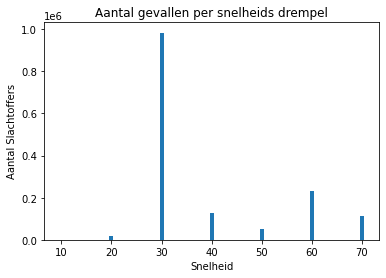

In [11]:
list_casulties_speed=[]
list_speed_casulties=[]
for x in df2.collect():
    list_casulties_speed.append(x[0])
    list_speed_casulties.append(int(x[1]))
print(list_casulties_speed)
plt.bar(list_speed_casulties,list_casulties_speed)
plt.title("Aantal gevallen per snelheids drempel")
plt.xlabel('Snelheid')
plt.ylabel('Aantal Slachtoffers')
plt.show()

In [12]:
local_authority=[]
for row in df1.collect():
    local_authority.append(row.local_authority)
print(local_authority)

['Isles of Scilly', 'East Renfrewshire', 'Orkney Islands', 'Na h-Eileanan Siar', 'Gloucester', 'Epsom and Ewell', 'Slough', 'Shetland Islands', 'Oadby and Wigston', 'Barking and Dagenham', 'Forest of Dean', 'Castle Point', 'Corby', 'Stevenage', 'Three Rivers', 'Croydon', 'East Ayrshire', 'Adur', 'West Lothian', 'Sutton', 'Watford', 'Surrey Heath', 'Hertsmere', 'Rochford', 'West Dunbartonshire', 'Highland', 'South Ribble', 'Gedling', 'East Dunbartonshire', 'Rutland', 'Clackmannanshire', 'Midlothian', 'Havant', 'Broxbourne', 'Redditch', 'Rushmoor', 'Blackpool', 'Welwyn Hatfield', 'Richmondshire', 'Crawley', 'Gosport', 'Luton', 'Hart', 'Fareham', 'Eastbourne', 'Thurrock', 'Perth and Kinross', 'Denbighshire', 'Spelthorne', 'Blaby', 'Bury', 'Woking', 'Newham', 'Knowsley', 'Melton', 'South Bucks', 'Dartford', 'Bracknell Forest', 'Selby', 'Merton', 'Harlow', 'Runnymede', 'Maldon', 'Tamworth', 'Mole Valley', 'Tewkesbury', 'East Cambridgeshire', 'Ipswich', 'Boston', 'Harborough', 'Reigate and B

In [13]:
choose_local_authority = widgets.Dropdown(
    options=local_authority,
    value='Isles of Scilly',
    description='Authority:',
)
displayMap=True

def load_map_points(local_authority):
    df1 = sqlContext.sql("SELECT * from pubsTable where local_authority='"+local_authority+"'")
    local_authority_coordinates = (df1.collect()[0].latitude,df1.collect()[0].longitude)
    map = folium.Map(location=local_authority_coordinates, zoom_start=11.5)
    if displayMap:
        display(map)
    displayMap=False
    ## testing 
    counter=0
    for row in df1.collect():
        folium.Marker(location = [row.latitude,row.longitude]).add_to(map)
def on_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        load_map_points(change['new'])
choose_local_authority.observe(on_change)
display(display(choose_local_authority))


Dropdown(description='Authority:', options=('Isles of Scilly', 'East Renfrewshire', 'Orkney Islands', 'Na h-Ei…

None

In [14]:
#Trying to create a map with pubs
UK_COORDINATES = (53.5500, -6.4333)
map = folium.Map(location=UK_COORDINATES, zoom_start=5.5)
## testing 
print(map)
counter=0

display(map)

In [15]:
map

In [18]:
### twee dataframes in één dataframe joinen m.b.v. ID(Accident_Index). Beide dataframes hebben evenveel records.
joined = accidentData_df.alias("A").join(casualtiesData_df.alias("B"),col("A.Accident_Index") == col("B.Accident_Index"),"inner").select(col("A.Accident_Index"), col("A.Longitude"),col("A.Latitude"), col("A.Police_Force"), col("A.Accident_Severity"), col("A.Number_of_Vehicles"), col("A.Number_of_Casualties"), col("A.Date"), col("A.Day_of_Week"),col("A.Time"), col("A.1st_Road_Class"), col("A.Road_Type"), col("A.Speed_limit"), col("A.Junction_Detail"), col("A.Junction_Control"), col("A.Light_Conditions"), col("A.Weather_Conditions"), col("A.Road_Surface_Conditions"), col("A.Special_Conditions_at_Site"), col("A.Urban_or_Rural_Area"), col("A.Did_Police_Officer_Attend_Scene_of_Accident"), col("A.LSOA_of_Accident_Location"), col("B.Casualty_Class"), col("B.Sex_of_Casualty"), col("B.Age_of_Casualty"), col("B.Casualty_Severity"), col("B.Pedestrian_Location"), col("B.Car_Passenger"), col("B.Casualty_Type")).toDF("Accident_Index", "Longitude","Latitude","Police_Force", "Accident_Severity","Number_of_Vehicles", "Number_of_Casualties", "Date", "Day_of_Week","Time","1st_Road_Class", "Road_Type", "Speed_limit","Junction_Detail", "Junction_Control","Light_Conditions", "Weather_Conditions","Road_Surface_Conditions","Special_Conditions_at_Site","Urban_or_Rural_Area", "Did_Police_Officer_Attend_Scene_of_Accident", "LSOA_of_Accident_Location","Casualty_Class","Sex_of_Casualty","Age_of_Casualty","Casualty_Severity","Pedestrian_Location","Car_Passenger","Casualty_Type")

In [19]:
### Soorten voertuigen
from collections import Counter
from pyspark.sql.functions import count

joined.groupby("Casualty_Type").count().show(22)
print("Ongeveer 83% van alle accidenten werden veroorzaakt in een auto (Casualty_Type 9). Andere voertuigen zijn vooral brommers onderverdeeld in groepen (50cc, 125cc, 500cc enzo) andere voertuigen zijn wel een beetje raar boerderij voertuigen? taxi? trambestuurders? zelfs paarden. Kans dat er iemand met een paard naar een pub gaat is vrij klein denk ik. Dus wat doen wij? enkel autos en brommers bijhouden en de rest verwijderen of gewoon zo laten?")

+-------------+-------+
|Casualty_Type|  count|
+-------------+-------+
|           11|  57485|
|            3|  63957|
|            8|  28020|
|           22|    331|
|           16|   1116|
|            0| 251398|
|           98|     50|
|            5|  80881|
|           18|    102|
|           17|   1007|
|           90|   9338|
|           19|  45911|
|           23|     17|
|           97|    193|
|            9|1270126|
|            1| 169654|
|           20|   5500|
|           10|   6767|
|            4|  22117|
|           21|  11037|
|            2|  33572|
+-------------+-------+

Ongeveer 83% van alle accidenten werden veroorzaakt in een auto (Casualty_Type 9). Andere voertuigen zijn vooral brommers onderverdeeld in groepen (50cc, 125cc, 500cc enzo) andere voertuigen zijn wel een beetje raar boerderij voertuigen? taxi? trambestuurders? zelfs paarden. Kans dat er iemand met een paard naar een pub gaat is vrij klein denk ik. Dus wat doen wij? enkel autos en brommers bijhoud

In [20]:
### Casualty Class
joined.groupby("Casualty_Class").count().show()
print("Casualty_Class geeft aan of de persoon in kwestie een passagier(2), bestuurder van een voertuig(1) of een voetganger(3) is. Aangezien wij opzoek zijn naar accidenten die werden veroorzaakt door dronken mensen, lijkt het mij onwaarschijnlijk dat passagiers van voertuigen de oorzaak kunnen zijn van een accident dus ik dacht misschien Casualty_Class(2) weglaten?")

+--------------+-------+
|Casualty_Class|  count|
+--------------+-------+
|             3| 251398|
|             1|1307284|
|             2| 499897|
+--------------+-------+

Casualty_Class geeft aan of de persoon in kwestie een passagier(2), bestuurder van een voertuig(1) of een voetganger(3) is. Aangezien wij opzoek zijn naar accidenten die werden veroorzaakt door dronken mensen, lijkt het mij onwaarschijnlijk dat passagiers van voertuigen de oorzaak kunnen zijn van een accident dus ik dacht misschien Casualty_Class(2) weglaten?


In [21]:
### Leeftijd
joined.groupby("Age_of_Casualty").count().show(121)
print("Er zitten hier records van kinderen 3, 8 jaar enzo. in die andere excel bestand die jij hebt gestuurd was alle info over 16+ mensen. Dus hier weeral al die kinderen verwijderen? Age_of_Casualty met waarde -1 zijn gevallen waar de leeftijd niet gekend is")

+---------------+-----+
|Age_of_Casualty|count|
+---------------+-----+
|             51|22497|
|              7|10372|
|             54|19253|
|             -1|45488|
|             15|21030|
|             11|18280|
|            101|    2|
|             29|38486|
|             69| 8114|
|             42|33251|
|             73| 6948|
|             87| 2511|
|             64|11110|
|              3| 7515|
|             30|45375|
|             34|33905|
|             59|15507|
|              8|11348|
|             28|41181|
|             22|54072|
|             85| 3727|
|             35|37741|
|             52|21720|
|             16|38820|
|              0| 1715|
|             71| 7175|
|             98|   71|
|             47|27522|
|             99|   70|
|             96|  145|
|             43|32014|
|              5| 8934|
|             31|35359|
|            100|    4|
|             18|72211|
|             70| 9663|
|             61|13479|
|             27|42096|
|             75

In [ ]:
def sort_age(age):
    age = int(age)
    if 16 <= age < 25:
        return "16-24"
    elif 25<=age <35:
        return "25-34"
    elif 35<= age <45:
        return "35-44"
    elif 45<= age <60:
        return "45-60"
    elif 60<= age <120:
        return "+60"
    elif 0 <= age <16:
        return "Child"
    else:
        return "Unknown"
sort_age(24)
joined = joined.withColumn("Age_of_Casualty", col("Age_of_Casualty").cast("int"))
joined = joined.withColumnRenamed("1st_Road_Class", "First_Road_Class")
joined2 = joined.rdd.map(lambda x: (x.Accident_Index, x.Longitude, 
                                    x.Latitude, x.Police_Force, x.Accident_Severity, x.Number_of_Vehicles, 
                                    x.Number_of_Casualties, x.Date, x.Day_of_Week, x.Time, x.First_Road_Class, 
                                    x.Road_Type, x.Speed_limit, x.Junction_Detail, x.Junction_Control, x.Light_Conditions, 
                                    x.Weather_Conditions,
                                    x.Road_Surface_Conditions, x.Special_Conditions_at_Site,
                                    x.Urban_or_Rural_Area, x.Did_Police_Officer_Attend_Scene_of_Accident, x.LSOA_of_Accident_Location, x.Casualty_Class, x.Sex_of_Casualty, x.Age_of_Casualty, x.Casualty_Severity, x.Pedestrian_Location, x.Car_Passenger, x.Casualty_Type, sort_age(x.Age_of_Casualty)))

joined2 = joined2.toDF(["Accident_Index", "Longitude" , "Latitude" , "Police_Force" , "Accident_Severity" ,
       "Number_of_Vehicles" , "Number_of_Casualties" , "Date" , "Day_of_Week" , "Time" , "1st_Road_Class" , "Road_Type" , "Speed_limit" , "Junction_Detail" , "Junction_Control" , "Light_Conditions" , "Weather_Conditions" , "Road_Surface_Conditions" , "Special_Conditions_at_Site" , "Urban_or_Rural_Area" ,
       "Did_Police_Officer_Attend_Scene_of_Accident" , "LSOA_of_Accident_Location" , "Casualty_Class" , "Sex_of_Casualty" , 
       "Age_of_Casualty" , "Casualty_Severity" , "Pedestrian_Location" , "Car_Passenger" , "Casualty_Type" , "Age_Cat"])


In [ ]:
joined2.show(20, vertical= True)

In [ ]:
### Aantal accidenten per leeftijdscategorie
joined2.groupby("Age_Cat").count().show()

In [ ]:
### Aantal accidenten per Leeftijdscategorie en ernstigheid van het incident
joined2.groupby("Age_Cat", "Accident_Severity").count().show()
print("Zal proberen om er een staafdiagram van te maken")